# Using Femwell to simulate the modes within a SiO2 Waveguide, also calc supported modes based on varying widths

In [ ]:
# Install dependencies
# !pip install femwell

In [34]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
import shapely.affinity
from shapely.geometry import box
from scipy.constants import epsilon_0, speed_of_light
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.visualization import plot_domains

In [35]:
### Use shapely to create the waveguide centered at 0,0 with a mesh that ranges from resolution 
### 30 nm over 500nm 

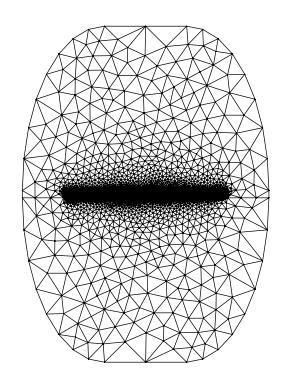

In [36]:
wg_width = 5
wg_thickness = 0.22
core = shapely.geometry.box(-wg_width / 2, 0, +wg_width / 2, wg_thickness)
env = shapely.affinity.scale(core.buffer(5, resolution=8), xfact=0.5)

polygons = OrderedDict(
    core=core,
    box=clip_by_rect(env, -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(env, -np.inf, 0, np.inf, np.inf),
)

resolutions = dict(core={"resolution": 0.03, "distance": 0.5})

# Plot the mesh
mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=10))
mesh.draw().show()

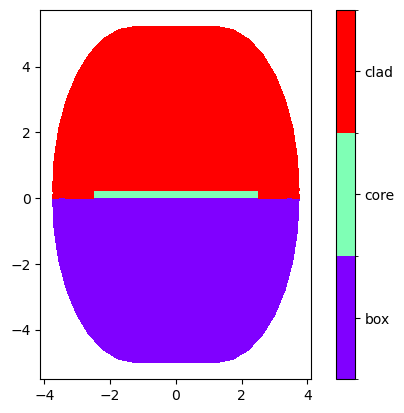

In [37]:
# Plot the three domains, BOX - Buried Oxide, Cladding, Core
plot_domains(mesh)
plt.show()

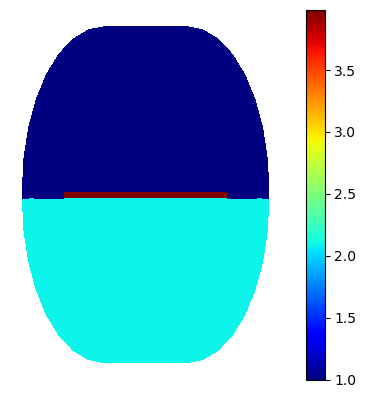

In [38]:
# permittivity_r 
basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
for subdomain, n in {"core": 1.9963, "box": 1.444, "clad": 1}.items():
    epsilon[basis0.get_dofs(elements=subdomain)] = n**2
basis0.plot(epsilon, colorbar=True).show()

Effective refractive index: 1.5305+0.0000j


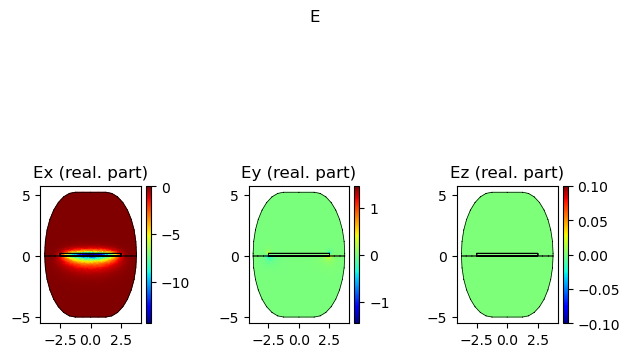

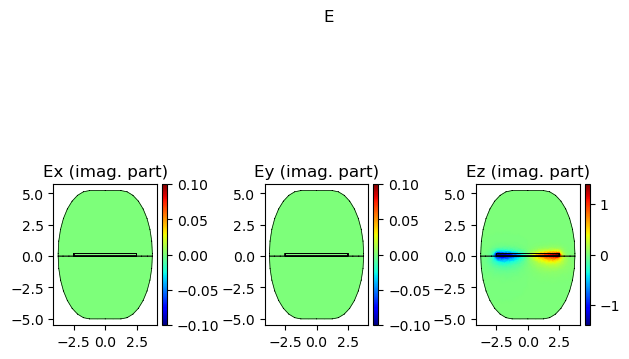

Effective refractive index: 1.5093+0.0000j


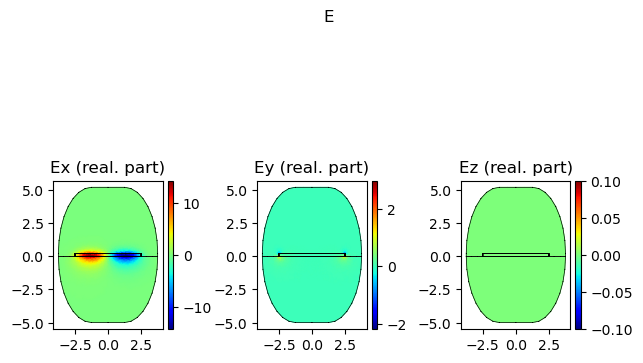

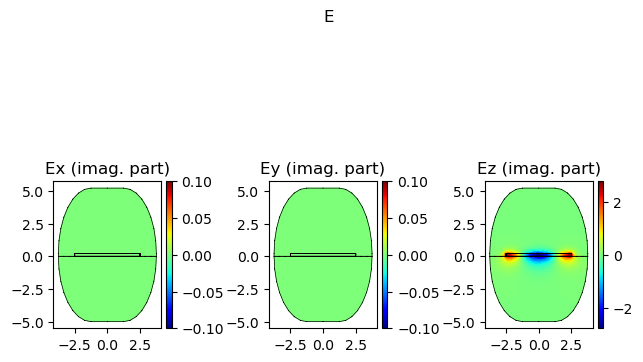

In [39]:
# Compute Modes for 
wavelength = 1.55

modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=2, order=2)
for mode in modes:
    print(f"Effective refractive index: {mode.n_eff:.4f}")
    mode.show("E", part="real", colorbar=True)
    mode.show("E", part="imag", colorbar=True)

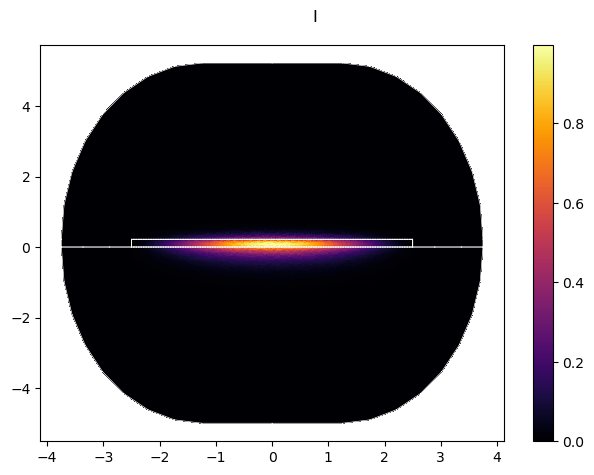

In [40]:
modes[0].show("I", colorbar=True)

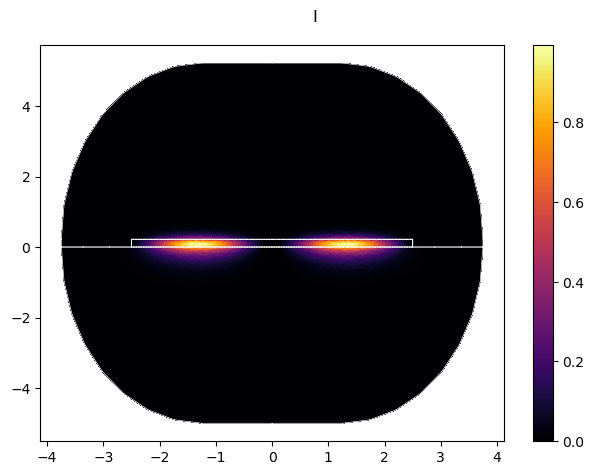

In [41]:
modes[1].show("I", colorbar=True)

### Now, let’s calculate with the modes: What percentage of the mode is within the core for the calculated modes?

In [42]:
powers_in_waveguide = []
confinement_factors_waveguide = []

for mode in modes:
    powers_in_waveguide.append(mode.calculate_power(elements="core"))
    confinement_factors_waveguide.append(mode.calculate_confinement_factor(elements="core"))
print(powers_in_waveguide)
print(confinement_factors_waveguide)

[(0.4268577273405584+0j), (0.4206110084810343+0j)]
[(0.556294664844286+0j), (0.5544439408524144+0j)]


In [43]:
powers_in_waveguide = []
confinement_factors_waveguide = []

for mode in modes:
    powers_in_waveguide.append(mode.calculate_power(elements="clad"))
    confinement_factors_waveguide.append(mode.calculate_confinement_factor(elements="clad"))
print(powers_in_waveguide)
print(confinement_factors_waveguide)

[(0.12750383781384017+0j), (0.12681206278506557+0j)]
[(0.08380977800218394+0j), (0.08605926860993457+0j)]


In [44]:
powers_in_waveguide = []
confinement_factors_waveguide = []

for mode in modes:
    powers_in_waveguide.append(mode.calculate_power(elements="box"))
    confinement_factors_waveguide.append(mode.calculate_confinement_factor(elements="box"))
print(powers_in_waveguide)
print(confinement_factors_waveguide)

[(0.44563843484560145+0j), (0.45257692873390026+0j)]
[(0.42076721626523395+0j), (0.43421904934568367+0j)]


### Vary Wide of waveguide and calc the effect refractive indicies of the modes 

In [64]:
wavelength = 1.55
num_modes = 8
widths = np.linspace(0.2, 3.5, 100)
height = 0.3

all_neffs = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))
for i, width in enumerate(tqdm(widths)):
    core = box(0, 0, width, height)
    polygons = OrderedDict(
        core=core,
        box=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, -np.inf, np.inf, 0),
        clad=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, 0, np.inf, np.inf),
    )

    resolutions = {"core": {"resolution": 0.1, "distance": 1}}

    mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))

    basis0 = Basis(mesh, ElementTriP0())
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {"core": 1.9963, "box": 1.444, "clad": 1}.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes)
    all_neffs[i] = np.real([mode.n_eff for mode in modes])
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


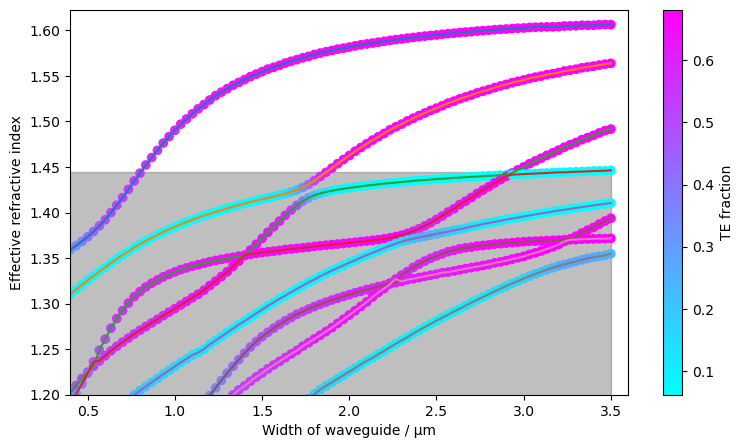

In [65]:
plt.figure(figsize=(9,5))
all_neffs = np.real(all_neffs)
plt.xlabel("Width of waveguide / µm")
plt.ylabel("Effective refractive index")
plt.fill_between(widths, 1.444, alpha=0.5, color="gray")
plt.ylim(1.2, np.max(all_neffs) + 0.1 * (np.max(all_neffs) - 1.444))
plt.xlim(0.4,3.6)
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")
plt.colorbar().set_label("TE fraction")
plt.show()

In [52]:
### Gray box indicates where n_r < n_box and therefore will not be guided

In [ ]:
## Therefore the waveguide is single mod from 750nm to 1700nm 
##